In [282]:
import numpy as np
import cv2
from flowToColor import *
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline


In [224]:
def myFlow(img1, img2, window_size, threshold):
    # Convert images to grayscale and scale intensity values to [0, 1]
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

    #     Resize images to half their size for better performance
#     img1_gray = cv2.resize(img1_gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
#     img2_gray = cv2.resize(img2_gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    
    # Compute spatial derivatives using a five-tap derivative filter
    dx_filter = np.array([-1, 8, 0, -8, 1]) / 12.0
    dy_filter = np.array([-1, 8, 0, -8, 1]) / 12.0
    Ix = cv2.filter2D(img1_gray, -1, dx_filter.reshape(-1, 1))
    Iy = cv2.filter2D(img1_gray, -1, dy_filter.reshape(1, -1))
    
    # Compute temporal derivative by subtracting blurred images
    img1_blur = cv2.GaussianBlur(img1_gray, (3, 3), sigmaX=1)
    img2_blur = cv2.GaussianBlur(img2_gray, (3, 3), sigmaX=1)
    It = img2_blur - img1_blur
    
    u = np.zeros_like(img1_gray)
    v = np.zeros_like(img1_gray)
    valid = np.zeros_like(img1_gray, dtype=bool)

    Sxx = cv2.boxFilter(Ix**2, -1, (window_size, window_size), normalize=True)
    Syy = cv2.boxFilter(Iy**2, -1, (window_size, window_size), normalize=True)
    Sxy = cv2.boxFilter(Ix*Iy, -1, (window_size, window_size), normalize=True)
    Stx = cv2.boxFilter(Ix*It, -1, (window_size, window_size), normalize=True)
    Sty = cv2.boxFilter(Iy*It, -1, (window_size, window_size), normalize=True)

    # Compute flow vectors for each pixel
    for i in range(window_size, img1_gray.shape[0]-window_size):
        for j in range(window_size, img1_gray.shape[1]-window_size):
            # Construct the matrix A
            A = np.array([[Sxx[i,j], Sxy[i,j]],
                          [Sxy[i,j], Syy[i,j]]])

            # Check if A is invertible
            if np.min(np.abs(np.linalg.eigvals(A))) >= threshold:
                # Compute the flow vector using the equation u = -inv(A)*[Stx, Sty]
                b = np.array([-Stx[i,j], -Sty[i,j]])
                flow = np.linalg.solve(A, b)

                # Store the flow vector and mark as valid
                u[i,j] = flow[0]
                v[i,j] = flow[1]
                valid[i,j] = True

    # Set invalid flow vectors to zero
    u[~valid] = 0
    v[~valid] = 0

    return u,v, valid

In [278]:
corridor1 = cv2.imread('./Sequences/corridor/bt_0.png')
corridor2 = cv2.imread('./Sequences/corridor/bt_1.png')
u,v,valid = myFlow(corridor1, corridor2, 15, 0.001)
flow = np.dstack((u,v))
flowImg = flowToColor(flow)

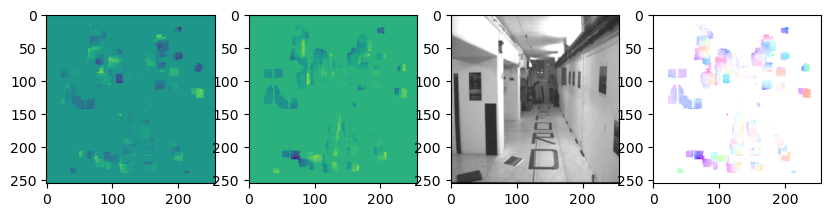

In [299]:
fig, axs = plt.subplots(1, 4, figsize=(10,10))

# Plot the images in each of the subplots
axs[0].imshow(u)
axs[1].imshow(v)
axs[2].imshow(corridor1)
axs[3].imshow(flowImg)

# Show the figure
plt.show()

In [288]:
def myWarp(img2, u, v):
    """Warps img2 using the optical flow field (u,v) and returns the warped image."""
    height, width = img2.shape[:2]
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    # Add flow to grid coordinates
    x_flow = x + u
    y_flow = y + v
    # Create interpolation functions for img2
    interp_func = RectBivariateSpline(np.arange(height), np.arange(width), img2)
    # Sample img2 at the warped grid coordinates
    warped = interp_func.ev(y_flow, x_flow)
    # Set pixels outside of img2 to zero
    invalid_mask = np.logical_or(np.isnan(warped), (x_flow < 0) | (x_flow > width-1) | (y_flow < 0) | (y_flow > height-1))
    warped[invalid_mask] = 0
    return warped

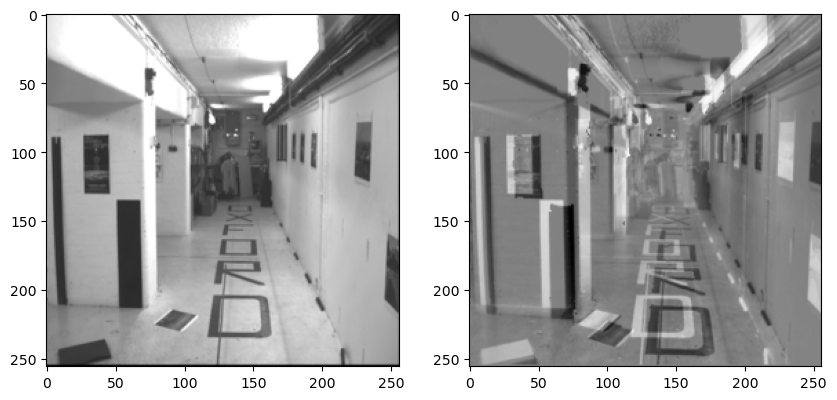

In [297]:
img1gray = cv2.cvtColor(corridor1, cv2.COLOR_BGR2GRAY)
img2gray = cv2.cvtColor(corridor2, cv2.COLOR_BGR2GRAY)
warped = myWarp(img2gray, u, v)
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(corridor1)
axs[1].imshow(warped-img1gray,cmap='gray')
plt.show()

In [300]:
sphere0 = cv2.imread('./Sequences/sphere/sphere_0.png')
sphere1 = cv2.imread('./Sequences/sphere/sphere_1.png')
u,v,valid = myFlow(sphere0, sphere1, 15, 0.0001)
# for the following two images for some reason, the lesser my threshold is, the better the flow can be visualized 
flow = np.dstack((u, v))
img = flowToColor(flow)

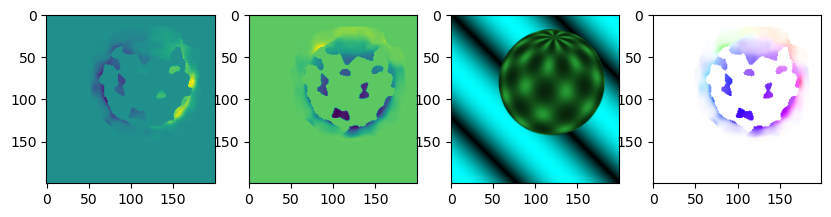

In [301]:
fig, axs = plt.subplots(1, 4, figsize=(10,10))

# Plot the images in each of the subplots
axs[0].imshow(u)
axs[1].imshow(v)
axs[2].imshow(sphere0)
axs[3].imshow(img)

# Show the figure
plt.show()

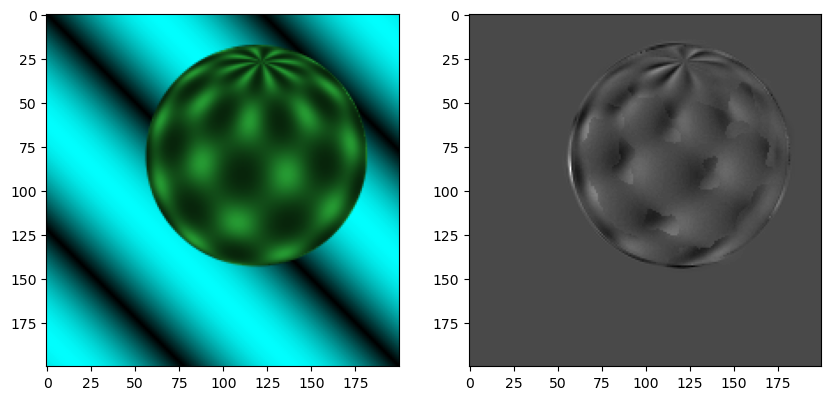

In [302]:
img1gray = cv2.cvtColor(sphere0, cv2.COLOR_BGR2GRAY)
img2gray = cv2.cvtColor(sphere1, cv2.COLOR_BGR2GRAY)
warped = myWarp(img2gray, u, v)
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(sphere0)
axs[1].imshow(warped-img1gray,cmap='gray')
plt.show()

In [303]:
synth_0 = cv2.imread('./Sequences/synth/synth_0.png')
synth_1 = cv2.imread('./Sequences/synth/synth_1.png')
u,v,valid = myFlow(synth_0, synth_1, 15, 0.0001)
flow = np.dstack((u, v))
img = flowToColor(flow)

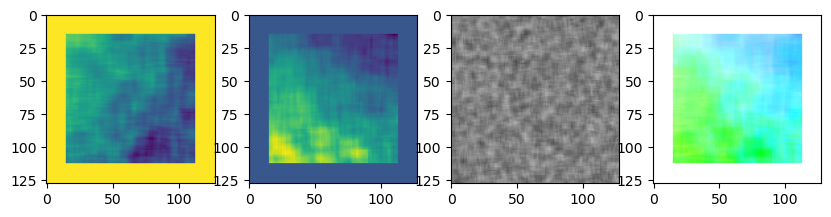

In [304]:
fig, axs = plt.subplots(1, 4, figsize=(10,10))

# Plot the images in each of the subplots
axs[0].imshow(u)
axs[1].imshow(v)
axs[2].imshow(synth_0)
axs[3].imshow(img)

# Show the figure
plt.show()

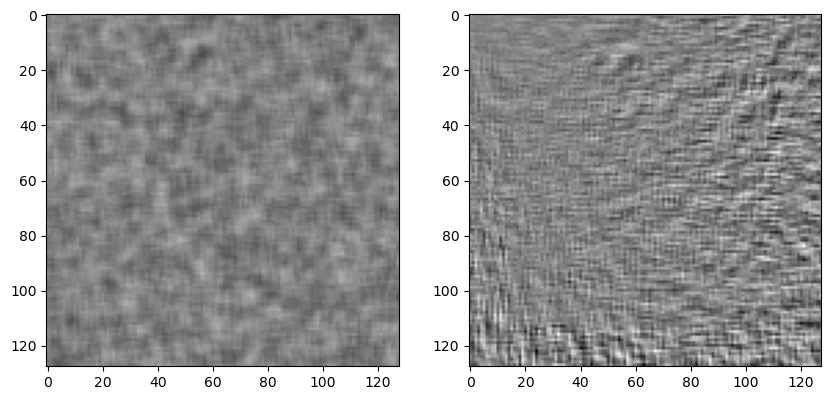

In [305]:
img1gray = cv2.cvtColor(synth_0, cv2.COLOR_BGR2GRAY)
img2gray = cv2.cvtColor(synth_1, cv2.COLOR_BGR2GRAY)
warped = myWarp(img2gray, u, v)
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(synth_0)
axs[1].imshow(warped-img1gray,cmap='gray')
plt.show()

### Comments on what effect changing the window size has
By changing the window size, I noticed that for smaller window sizes, the algorithm captures subtle motions whereas with the large window size, the algorithm does the opposite.
Also for some reason, my threshold had to be really low to be able to correctly visualize the flow field, so 0.01 didn't work, 0.001 worked, but the smaller it was, the better the flowImage